# Detect Phishing URLs
### Capstone 3 - Preprocessing and Modeling
Michael Garber

#### High-Level Steps
1. Preprocessing
    1. Create dummy/indicator features for categorical variables
    2. Standardize/scale numeric features
    3. Train/Test Split 
2. Modeling
    1. Fit your models with a training dataset
    2. Review model outcomes — Iterate over additional models as needed. Cross-validate
    3. Identify the final model that you think is the best model for this project

In [4]:
# Import Libraries
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import TargetEncoder     # requires scikit-learn 1.3 or greater
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, auc
import keras
from keras import layers
import seaborn as sns
import matplotlib.pyplot as plt

#### Preprocessing

In [6]:
# Import Data set
dataDir = os.path.join('../data/interim/urlData_raw.csv')
urlData = pd.read_csv(dataDir)

C:\Users\MG-Laptop\AppData\Local\Temp\ipykernel_12624\2659773463.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  urlData = pd.read_csv(dataDir)


In [7]:
# add new useful feature: URL length
urlData['url_Length'] = urlData['url'].apply(len)

In [8]:
# Data Info
urlData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450175 entries, 0 to 450174
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Unnamed: 0        450175 non-null  int64 
 1   key_0             445854 non-null  object
 2   url               450175 non-null  object
 3   type              450175 non-null  object
 4   parsedUrl         450175 non-null  object
 5   urlPart_scheme    450175 non-null  object
 6   subDomain         379885 non-null  object
 7   domain            450167 non-null  object
 8   tld               445854 non-null  object
 9   urlPart_path      444917 non-null  object
 10  urlPart_query     65541 non-null   object
 11  urlPart_fragment  359 non-null     object
 12  tld_join          445854 non-null  object
 13  Domain            445451 non-null  object
 14  Type              445451 non-null  object
 15  TLD Manager       445451 non-null  object
 16  isIPaddress       450175 non-null  boo

**Additional data cleaning** - identify features that have **missing values** (that we ares till planning on keeping)
- subDomain
- domain
- tld
- urlPart_path
- urlPart_query
- urlPart_fragment
- Type
- TLD Manager    

In [10]:
# Additional data cleaning - set missing values to zero
values = {
    'subDomain': '0',
    'domain': '0',
    'tld': '0',
    'urlPart_path': '0',
    'urlPart_query': '0',
    'urlPart_fragment': '0',
    'Type': '0',
    'TLD Manager': '0'}

urlData = urlData.fillna(value=values)

In [11]:
# Data Info - checking NULLs again (key and tld will be dropped)
urlData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450175 entries, 0 to 450174
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Unnamed: 0        450175 non-null  int64 
 1   key_0             445854 non-null  object
 2   url               450175 non-null  object
 3   type              450175 non-null  object
 4   parsedUrl         450175 non-null  object
 5   urlPart_scheme    450175 non-null  object
 6   subDomain         450175 non-null  object
 7   domain            450175 non-null  object
 8   tld               450175 non-null  object
 9   urlPart_path      450175 non-null  object
 10  urlPart_query     450175 non-null  object
 11  urlPart_fragment  450175 non-null  object
 12  tld_join          445854 non-null  object
 13  Domain            445451 non-null  object
 14  Type              450175 non-null  object
 15  TLD Manager       450175 non-null  object
 16  isIPaddress       450175 non-null  boo

In [12]:
urlData.head()

,Unnamed: 0,key_0,url,type,parsedUrl,urlPart_scheme,subDomain,domain,tld,urlPart_path,urlPart_query,urlPart_fragment,tld_join,Domain,Type,TLD Manager,isIPaddress,isPhish_bool,url_Length
0,0,com,https://www.google.com,legitimate,"ParseResult(scheme='https', netloc='www.google...",https,www,google,com,0,0,0,com,.com,generic,VeriSign Global Registry Services,False,False,22
1,1,com,https://www.youtube.com,legitimate,"ParseResult(scheme='https', netloc='www.youtub...",https,www,youtube,com,0,0,0,com,.com,generic,VeriSign Global Registry Services,False,False,23
2,2,com,https://www.facebook.com,legitimate,"ParseResult(scheme='https', netloc='www.facebo...",https,www,facebook,com,0,0,0,com,.com,generic,VeriSign Global Registry Services,False,False,24
3,3,com,https://www.baidu.com,legitimate,"ParseResult(scheme='https', netloc='www.baidu....",https,www,baidu,com,0,0,0,com,.com,generic,VeriSign Global Registry Services,False,False,21
4,4,org,https://www.wikipedia.org,legitimate,"ParseResult(scheme='https', netloc='www.wikipe...",https,www,wikipedia,org,0,0,0,org,.org,generic,Public Interest Registry (PIR),False,False,25


In [13]:
urlData.columns[:]

Index(['Unnamed: 0', 'key_0', 'url', 'type', 'parsedUrl', 'urlPart_scheme',
       'subDomain', 'domain', 'tld', 'urlPart_path', 'urlPart_query',
       'urlPart_fragment', 'tld_join', 'Domain', 'Type', 'TLD Manager',
       'isIPaddress', 'isPhish_bool', 'url_Length'],
      dtype='object')

**Value Counts - urlPart_scheme**

In [15]:
#urlData[['url', 'urlPart_scheme', 'subDomain', 'tld', 'domain', 'type', 'TLD Manager', 'isIPaddress', 'isPhish_bool']]
pd.DataFrame(urlData['urlPart_scheme'].value_counts())

,count
urlPart_scheme,
https,352185
http,97947
httpss,35
ftp,8


**Value Counts - subDomain**

In [17]:
pd.DataFrame(urlData['subDomain'].value_counts())

,count
subDomain,
www,276100
0,70290
www.en,13626
www.music,1289
www.people,1228
...,...
www.ohv.parks,1
www.ohtheplaceswewillgo-books,1
www.ohr,1


**Value Counts - TLD Manager**

In [19]:
urlData['TLD Manager'].value_counts()

TLD Manager
VeriSign Global Registry Services                                                                               333004
Public Interest Registry (PIR)                                                                                   38393
Canadian Internet Registration Authority (CIRA) Autorité Canadienne pour les enregistrements Internet (ACEI)     10086
EDUCAUSE                                                                                                          6976
Nominet UK                                                                                                        5997
                                                                                                                 ...  
AS Domain Registry                                                                                                   1
University of Swaziland Department of Computer Science                                                               1
Dot London Domains Limited          

**Determine how to handle categorical features**

In [21]:
# Let's see cardinality / # of uniques for each feature - use to determine categorical fields to dummy and how to encode - one-hot vs label
urlData[['key_0', 'url', 'type', 'parsedUrl', 'urlPart_scheme',
       'subDomain', 'domain', 'tld', 'urlPart_path', 'urlPart_query',
       'urlPart_fragment', 'tld_join', 'Domain', 'Type', 'TLD Manager',
       'isIPaddress', 'isPhish_bool']].describe()

,key_0,url,type,parsedUrl,urlPart_scheme,subDomain,domain,tld,urlPart_path,urlPart_query,urlPart_fragment,tld_join,Domain,Type,TLD Manager,isIPaddress,isPhish_bool
count,445854,450175,450175,450175,450175,450175,450175,450175,450175,450175,450175,445854,445451,450175,450175,450175,450175
unique,415,450175,2,450132,4,32041,130747,832,317144,55325,72,415,360,5,260,2,2
top,com,https://www.google.com,legitimate,"ParseResult(scheme='http', netloc='new.sosnovs...",https,www,wikipedia,com,/,0,0,com,.com,generic,VeriSign Global Registry Services,False,False
freq,316414,1,345738,2,352185,276100,12895,316414,55253,384636,449816,316414,316414,376803,333004,447309,345738


> - Will use **mean encoding** for the **high cardinality columns** (e.x. domain) as using one-hot would create too many columns and with sparse data
> - Will **mean encode after test/train splitting** to **avoid data leakage**

In [23]:
# Select/Drop features - create new dataframe for this major data change
urlDataV2 = urlData.drop(['Unnamed: 0', 'key_0', 'url', 'type', 'parsedUrl', 'tld_join', 'Domain'], axis=1)

In [24]:
# View new DF
urlDataV2.head()

,urlPart_scheme,subDomain,domain,tld,urlPart_path,urlPart_query,urlPart_fragment,Type,TLD Manager,isIPaddress,isPhish_bool,url_Length
0,https,www,google,com,0,0,0,generic,VeriSign Global Registry Services,False,False,22
1,https,www,youtube,com,0,0,0,generic,VeriSign Global Registry Services,False,False,23
2,https,www,facebook,com,0,0,0,generic,VeriSign Global Registry Services,False,False,24
3,https,www,baidu,com,0,0,0,generic,VeriSign Global Registry Services,False,False,21
4,https,www,wikipedia,org,0,0,0,generic,Public Interest Registry (PIR),False,False,25


**Features to One-Hot encode**
- 'urlPart_scheme'
- 'Type'
- 'isIPaddress'
- 'isPhish_bool'

*...because they are lower cardinality*

In [26]:
# Let's rename "type" to a more descriptive name before encoding
urlDataV2 = urlDataV2.rename(columns={'Type':'TLD_type'})

##### Create dummies \ one-hot encode

In [28]:
# One-Hot encode features
urlDataV2 = pd.get_dummies(urlDataV2, columns=['urlPart_scheme', 'TLD_type', 'isIPaddress'])

In [29]:
# view new DF
urlDataV2.head()

,subDomain,domain,tld,urlPart_path,urlPart_query,urlPart_fragment,TLD Manager,isPhish_bool,url_Length,urlPart_scheme_ftp,urlPart_scheme_http,urlPart_scheme_https,urlPart_scheme_httpss,TLD_type_0,TLD_type_country-code,TLD_type_generic,TLD_type_generic-restricted,TLD_type_sponsored,isIPaddress_False,isIPaddress_True
0,www,google,com,0,0,0,VeriSign Global Registry Services,False,22,False,False,True,False,False,False,True,False,False,True,False
1,www,youtube,com,0,0,0,VeriSign Global Registry Services,False,23,False,False,True,False,False,False,True,False,False,True,False
2,www,facebook,com,0,0,0,VeriSign Global Registry Services,False,24,False,False,True,False,False,False,True,False,False,True,False
3,www,baidu,com,0,0,0,VeriSign Global Registry Services,False,21,False,False,True,False,False,False,True,False,False,True,False
4,www,wikipedia,org,0,0,0,Public Interest Registry (PIR),False,25,False,False,True,False,False,False,True,False,False,True,False


*Note: Due to use of **Target encoding**, we will **preprocess** data in a **modified order**...

    1. train/test split data
    2. target encode data
    3. Scale data

In [31]:
# one more peek at columns and object types
urlDataV2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450175 entries, 0 to 450174
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   subDomain                    450175 non-null  object
 1   domain                       450175 non-null  object
 2   tld                          450175 non-null  object
 3   urlPart_path                 450175 non-null  object
 4   urlPart_query                450175 non-null  object
 5   urlPart_fragment             450175 non-null  object
 6   TLD Manager                  450175 non-null  object
 7   isPhish_bool                 450175 non-null  bool  
 8   url_Length                   450175 non-null  int64 
 9   urlPart_scheme_ftp           450175 non-null  bool  
 10  urlPart_scheme_http          450175 non-null  bool  
 11  urlPart_scheme_https         450175 non-null  bool  
 12  urlPart_scheme_httpss        450175 non-null  bool  
 13  TLD_type_0    

##### Train/Test Split

In [33]:
# assign X & y
X = urlDataV2.drop(columns=['isPhish_bool'], axis=1)
y = urlDataV2['isPhish_bool']

# perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

##### Target/Mean Encode
> https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html#sklearn.preprocessing.TargetEncoder

In [35]:
# target encode (using auto-smoothing and cross-fitting)
targetEncoderAuto = TargetEncoder(smooth='auto')
colsToEncode = ['subDomain', 'domain', 'tld', 'urlPart_path', 'urlPart_query', 'urlPart_fragment', 'TLD Manager']

X_train_encoded = X_train.copy()
X_test_encoded  = X_test.copy()
X_train_encoded[colsToEncode] = targetEncoderAuto.fit_transform(X_train[colsToEncode], y_train)
X_test_encoded[colsToEncode]  = targetEncoderAuto.transform(X_test[colsToEncode])

In [36]:
# Check encoding results
pd.DataFrame(X_train_encoded).head()

,subDomain,domain,tld,urlPart_path,urlPart_query,urlPart_fragment,TLD Manager,url_Length,urlPart_scheme_ftp,urlPart_scheme_http,urlPart_scheme_https,urlPart_scheme_httpss,TLD_type_0,TLD_type_country-code,TLD_type_generic,TLD_type_generic-restricted,TLD_type_sponsored,isIPaddress_False,isIPaddress_True
53827,0.000000,0.641479,0.161896,0.231896,0.000000,0.231303,0.169271,117,False,False,True,False,False,False,True,False,False,True,False
167106,0.046707,0.000000,0.093039,0.231899,0.220104,0.231328,0.093039,48,False,False,True,False,False,False,True,False,False,True,False
40742,0.000122,0.000000,0.093039,0.231899,0.220104,0.231328,0.093039,41,False,False,True,False,False,False,True,False,False,True,False
150384,0.046984,0.000000,0.075147,0.000000,0.231899,0.231289,0.066304,51,False,False,True,False,False,True,False,False,False,True,False
441607,0.995231,1.000000,0.161578,0.231899,0.220104,0.231328,0.169355,67,False,True,False,False,False,False,True,False,False,True,False


> Encoding on columns 1-7 ('subDomain' to 'TLD Manager') looks good

##### Standardize and Scale

In [39]:
# MinMax Scale the data
scaler = MinMaxScaler()
scaler.fit(X_train_encoded)

X_train_preprocessed = scaler.transform(X_train_encoded)
X_test_preprocessed  = scaler.transform(X_test_encoded)

In [40]:
# Check scaling results
pd.DataFrame(X_test_preprocessed).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.047015,0.000000,0.161563,0.231898,0.22001,0.000025,0.169234,0.012576,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.047015,0.231898,0.316270,0.231898,0.22001,0.000025,0.169234,0.019081,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.047015,0.000000,0.161563,0.231898,0.22001,0.000025,0.169234,0.032090,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.047015,0.000000,0.092519,0.231898,0.22001,0.000025,0.092519,0.036860,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.047015,0.231898,0.092519,0.231898,0.22001,0.000025,0.092519,0.016912,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


#### Modeling

In [42]:
# Get Dataset Shape
X_shape = X_train_preprocessed.shape[1]
X_shape

19

In [43]:
# Build Model
model = keras.Sequential()
model.add(keras.Input(shape=(X_shape,)))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall'])

In [44]:
#View Model Structure
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 20)                  │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421 (1.64 KB)

 Trainable params: 421 (1.64 KB)

 Non-trainable params: 0 (0.00 B)

##### Fit Model

In [46]:
model.fit(X_train_preprocessed, y_train, validation_split=0.25)

7914/7914 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - Recall: 0.9799 - loss: 0.0553 - val_Recall: 0.9912 - val_loss: 0.0128


In [47]:
# predict with model
predictions = model.predict(X_test_preprocessed)

3517/3517 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [48]:
# make predictions boolean (0.5 threshold)
predictions_bool = predictions >= 0.5

##### Evaluate/compare models

In [50]:
# Classification Report
print(classification_report(y_test, predictions_bool))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     86403
        True       0.99      0.99      0.99     26141

    accuracy                           1.00    112544
   macro avg       1.00      1.00      1.00    112544
weighted avg       1.00      1.00      1.00    112544



> :( Where did my data leak?   

In [52]:
# Precision Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, predictions_bool)
auc_score = auc(recall, precision)

#https://www.geeksforgeeks.org/precision-recall-curve-ml/

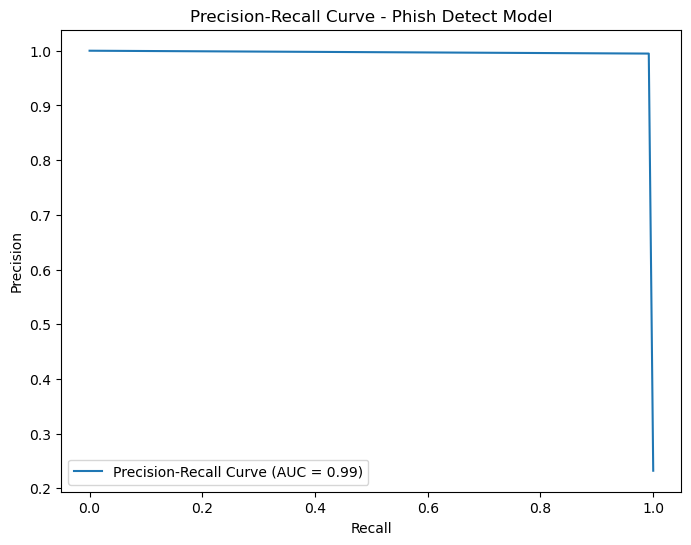

In [53]:
# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Phish Detect Model')
plt.legend()
plt.show()

##### Select Best Model

###### To do
- fix target encoding - encode only certain values and leave the rest alone
- revised preprocessing steps due to target encoding
    1. train/test split data
    2. target encode data
    3. Scale data
